In [1]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [2]:
SEED = 1

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Current Device:', device)

Current Device: mps


In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]     # ImageNet mean and std
IMAGENET_STD = [0.229, 0.224, 0.225]

IMAGENET_TRANSFORMS = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]
)

In [4]:
data_train = torchvision.datasets.Imagenette(root='./datasets/imagenette', split='train', download=False, transform=IMAGENET_TRANSFORMS)
data_val = torchvision.datasets.Imagenette(root='./datasets/imagenette', split='val', download=False, transform=IMAGENET_TRANSFORMS)

In [5]:
class ImagenetteDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, indices, transform=None):
        self.transforms = transform
        self.data = torch.utils.data.Subset(dataset, indices)

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transforms != None:
            image = self.transforms(image)

        label = 1 if label==3 else 0

        return image, label

    def __len__(self):
        return len(self.data)

In [6]:
data_train.class_to_idx

{'tench': 0,
 'Tinca tinca': 0,
 'English springer': 1,
 'English springer spaniel': 1,
 'cassette player': 2,
 'chain saw': 3,
 'chainsaw': 3,
 'church': 4,
 'church building': 4,
 'French horn': 5,
 'horn': 5,
 'garbage truck': 6,
 'dustcart': 6,
 'gas pump': 7,
 'gasoline pump': 7,
 'petrol pump': 7,
 'island dispenser': 7,
 'golf ball': 8,
 'parachute': 9,
 'chute': 9}

In [7]:
# Rebalance classes
# train_indices = [idx for idx, (image, label) in enumerate(data_train) if label==1 or label==4 or label==3]
# val_indices = [idx for idx, (image, label) in enumerate(data_val) if label==1 or label==4 or label==3]

# Ignore this for now because we're not actually training
train_indices = np.arange(len(data_train))
val_indices = np.arange(len(data_val))

In [8]:
data_train_chainsaw = ImagenetteDataset(data_train, train_indices)
data_val_chainsaw = ImagenetteDataset(data_val, val_indices)

In [9]:
train_loader = torch.utils.data.DataLoader(data_train_chainsaw, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val_chainsaw, batch_size=64, shuffle=False)

In [10]:
from mylibs.model import Resnet18, CNNClassifier

# model = CNNClassifier(num_classes=2)
model = Resnet18()
lr = 0.008
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for inputs, targets in train_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_train_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.

    return average_train_loss, accuracy

In [12]:
@torch.no_grad()
def test(model, data_loader, criterion, optimizer):
    model.eval()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for inputs, targets in test_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
    average_test_loss = running_loss / running_steps
    accuracy = n_correct / n_total * 100.0

    return average_test_loss, accuracy

In [13]:
for i in range(0):
    train_avg_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    if (i+1)%10 == 0:
        val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
        print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

In [14]:
# val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
# print('Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
#              .format(val_avg_loss, val_accuracy))

In [15]:
params = list(model.parameters())
weight = np.squeeze(params[-2].data.cpu().numpy())
print(params[-2].shape)
print(weight.shape)

torch.Size([1000, 512])
(1000, 512)


In [16]:
# Displays CAM and prediction.
#  img:           numpy array with shape (img_height, img_width, img_channels)
#  target_class:  prediction class
def cam(img, target_class=1):
    model.eval()

    img_transforms = transforms.Compose([
        transforms.ToPILImage(),
        IMAGENET_TRANSFORMS
    ])
    sample_img = img_transforms(img)

    sample_img = torch.autograd.Variable(sample_img.unsqueeze(0)) # What does autograd.Variable do?
    sample_img = sample_img.to(device)
    model.to(device)
    feats = model.get_features(sample_img).data.cpu().numpy()
    
    # Get prediction probability for target class
    output = model(sample_img)
    logits = F.softmax(output, dim=1).squeeze()
    pred_logit = logits[target_class].item()
    print('Probability: {:.5f}%'.format(pred_logit*100))

    _, nc, h, w = feats.shape
    r = feats.reshape((nc, h*w))

    c = weight[target_class].dot(r)
    c = c.reshape((h, w))
    c = c - np.min(c)
    c = c / np.max(c)
    c_i = np.uint8(255 * c)
    c_i = cv2.resize(c_i, (img.shape[1], img.shape[0]))

    #img = np.uint8(255 * img) # What does this line do?
    img = np.uint8(img)       #   I found that this line works better instead
    heatmap = cv2.cvtColor(cv2.applyColorMap(c_i, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    result = np.uint8(0.3 * heatmap + 0.5 * img)

    # Plot original image and CAM side-by-side
    plt.figure(1, figsize=(12,8))
    img_plot = plt.subplot(121)
    img_plot.axis('off')
    img_plot.imshow(img)
    cam_plot = plt.subplot(122)
    cam_plot.axis('off')
    cam_plot.imshow(result)
    plt.show()

In [17]:
IMAGENET_CHAINSAW_CLASS = 491

In [18]:
chainsaws = [
    'datasets/imagenette/imagenette2/val/n03000684/ILSVRC2012_val_00011951.JPEG',
    'datasets/imagenette/imagenette2/val/n03000684/n03000684_35991.JPEG'
]

not_chainsaws = [
    'datasets/imagenette/imagenette2/val/n03394916/ILSVRC2012_val_00007921.JPEG',
    'datasets/imagenette/imagenette2/val/n03445777/n03445777_261.JPEG',
    'examples/tabby_cat.jpg'
]

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Probability: 92.78544%


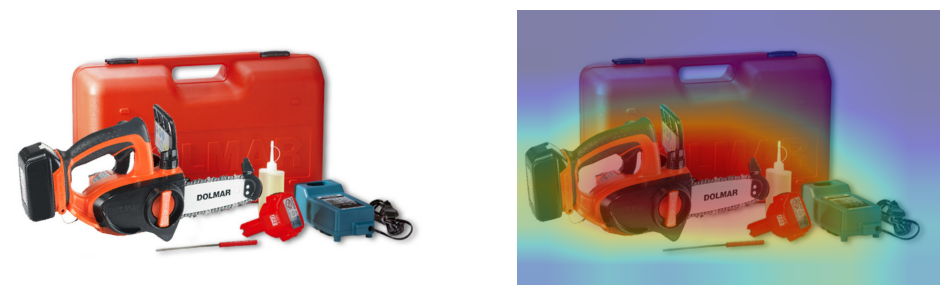

[[[135 115  88]
  [135 115  88]
  [136 116  89]
  ...
  [139  37  25]
  [104  46  26]
  [255 236 212]]

 [[134 114  87]
  [134 114  87]
  [135 115  88]
  ...
  [139  37  25]
  [104  46  26]
  [255 236 212]]

 [[133 113  86]
  [133 113  86]
  [134 114  87]
  ...
  [139  37  25]
  [104  46  26]
  [255 236 212]]

 ...

 [[110  38   0]
  [109  37   0]
  [107  37   1]
  ...
  [ 75  75  75]
  [ 71  71  71]
  [255 255 255]]

 [[110  36   0]
  [109  37   0]
  [107  37   1]
  ...
  [ 75  75  75]
  [ 72  72  72]
  [255 255 255]]

 [[110  36   0]
  [109  37   0]
  [107  37   1]
  ...
  [ 74  74  74]
  [ 73  73  73]
  [255 255 255]]]
Probability: 98.18911%


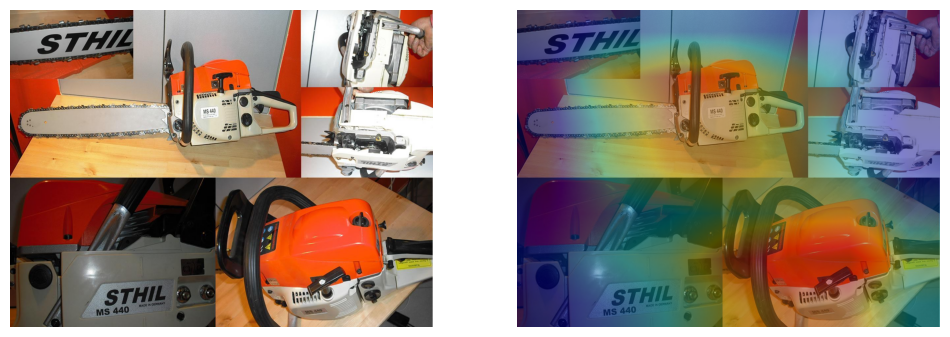

In [22]:
for im_path in chainsaws:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    print(im)
    cam(im, IMAGENET_CHAINSAW_CLASS)

Probability: 0.00081%


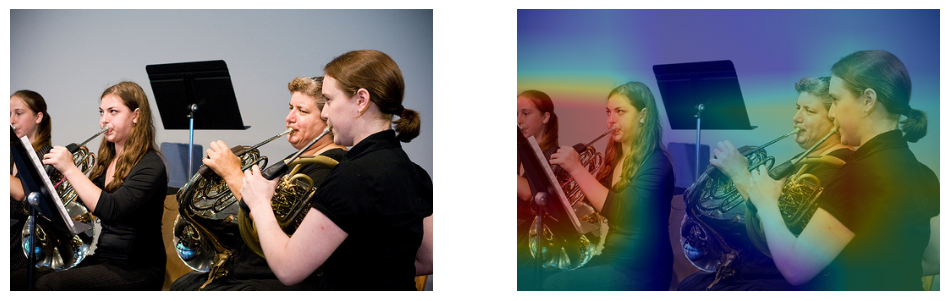

Probability: 0.00035%


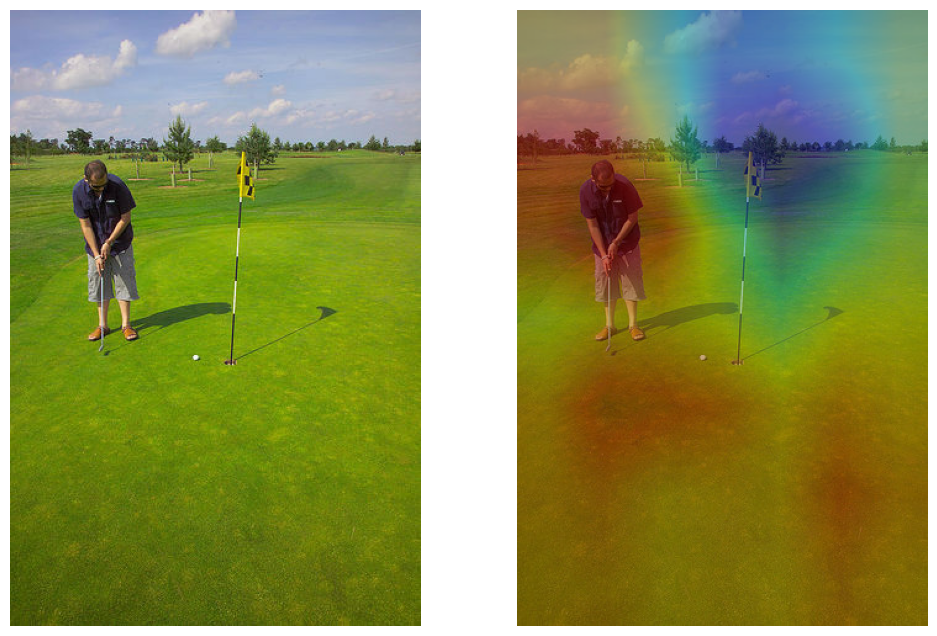

Probability: 0.00002%


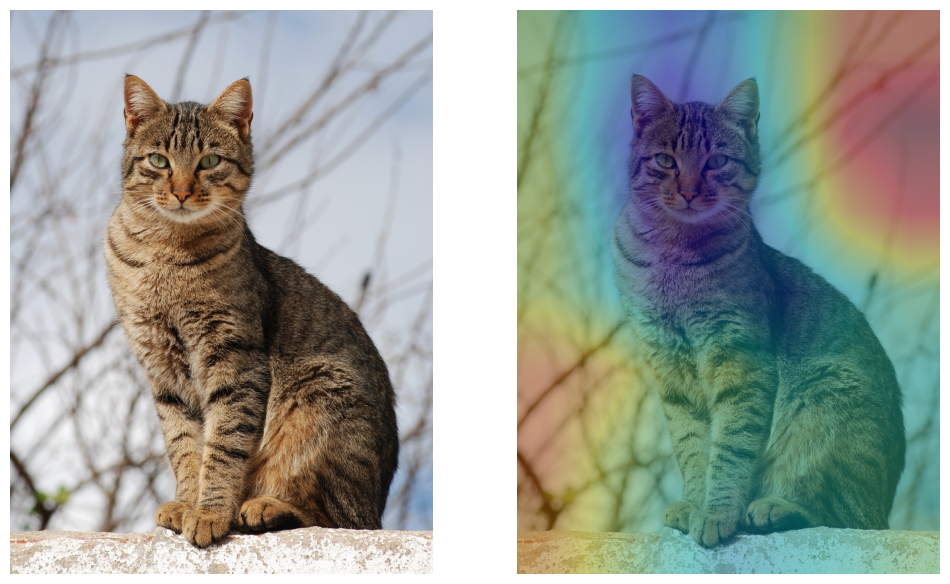

In [20]:
for im_path in not_chainsaws:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    cam(im, IMAGENET_CHAINSAW_CLASS)

Probability: 0.00002%


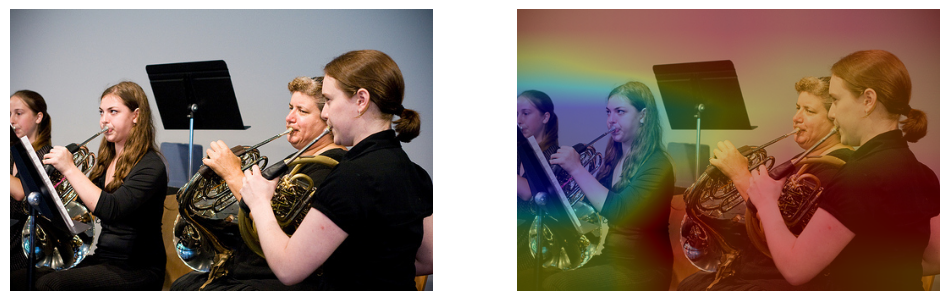

Probability: 0.00002%


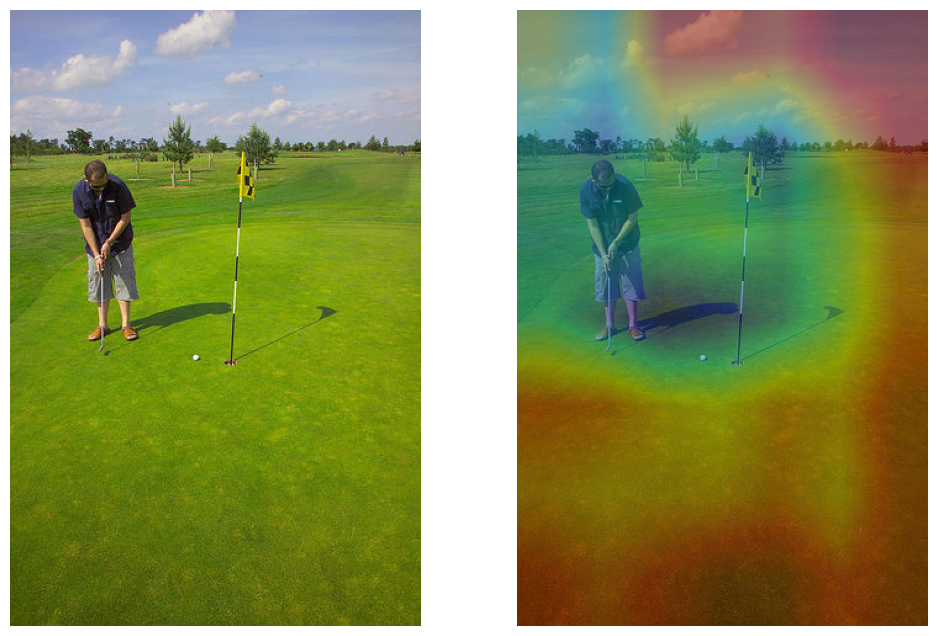

Probability: 41.41599%


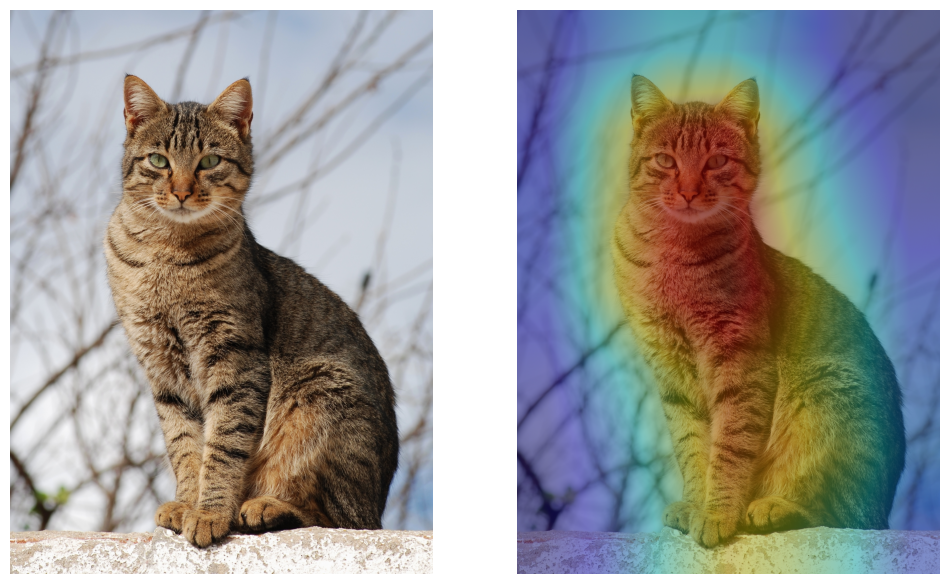

In [21]:
IMAGENET_TABBY_CLASS = 281

for im_path in not_chainsaws:
    im_raw = cv2.imread(im_path)
    im = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)
    cam(im, IMAGENET_TABBY_CLASS)